<h3> Predicting Forest Fires in Algeria</h3>


Forest fires are a type of  uncontrolled and unwanted fire that usually have a negative impact. In 2007, forest fires in the Atlas Mountains, located on the northern coast of Algeria, killed several people as it spread rapidly due to hot, dry winds.


In this project, `the problem we're willing to solve` is:
- Can we predict forest fires given the weather conditions by using $k$ nearest neighbours? 


Our dataset contains weather information on the Sidi Bel Abbès and the Bejaia région, and includes information such as :
- `day`,`month`,`year`: the date of the instance
- `Temperature`: the maximum temperature in degrees celsius
- `RH` : Relative humidity in percentages
- `Ws` : wind speed in kilometers per hour
- `Rain`: total amount of rain, in mm
- `Classes` : whether or not there was fire


The data set also includes indexes:
- `FFMC`: Fine Fuel Moisture Code
- `DMC` : Dull Moisture Code
- `DC`: Drought Code 
- `ISI`: Initial Spread Index
- `BUI`: Buildup Index
- `FWI`: Fire Weather Index

For more information on FWI, you can look at [this website](https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi).

first, we load the necessary libraries:

In [16]:
library(dplyr)
library(forcats)
library(readr)
library(GGally)
library(purrr)
library(rsample)
library(RColorBrewer)

options(repr.matrix.max.rows = 6)

set.seed(123)

## Package Version Checking ##
Here are the following versions you should have:
- dplyr: 1.1.0
- forcats: 1.0.0
- readr: 2.1.4
- GGally: 2.1.2
- purrr: 1.0.1
- rsample: 1.1.1
- RColorBrewer: 1.1.3


In [17]:
packageVersion("dplyr")
packageVersion("forcats")
packageVersion("readr")
packageVersion("GGally")
packageVersion("purrr")
packageVersion("rsample")
packageVersion("RColorBrewer")

[1] ‘1.0.10’

[1] ‘0.5.1’

[1] ‘2.1.2’

[1] ‘2.1.2’

[1] ‘0.3.4’

[1] ‘1.1.1’

[1] ‘1.1.2’

After inspecting the dataset, we take the data set's url from 
[this website](https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++) and load it to our notebook.

The dataset has one table for each region, so we make 2 datasets:

In [18]:
fire_url <- "data/Algerian_forest_fires_dataset_UPDATE.csv"
# this takes the bajaja region
forest_fire_bejaia <- read_csv(fire_url, skip = 1, n_max = 122)
# this takes the sidi region
forest_fire_sidi <- read_csv(fire_url, skip = 126)

Rows: 122 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): day, month, Classes
dbl (11): year, Temperature, RH, Ws, Rain, FFMC, DMC, DC, ISI, BUI, FWI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 122 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): day, month, DC, FWI, Classes
dbl (9): year, Temperature, RH, Ws, Rain, FFMC, DMC, ISI, BUI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


We got a warning message signalling a problem with the 44th row on  `forest_fire_sidi`, so we have to fix it:

In [19]:
slice(forest_fire_sidi,44)

day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>
14,07,2012,37,37,18,0.2,88.9,12.9,14.6 9,12.5,10.4,fire,NA


In [20]:
#The DC column and all the other columns after it had a parsing error, 
#so we just replace these values with the correct ones

forest_fire_sidi[44, 10] <- "14.6"
forest_fire_sidi[44, 11] <- 9
forest_fire_sidi[44, 12] <- 12.5
forest_fire_sidi[44, 13] <- "10.4"
forest_fire_sidi[44, 14] <- "fire"

In [21]:
# We check again to make sure it's fixed
slice(forest_fire_sidi,44)

day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>
14,07,2012,37,37,18,0.2,88.9,12.9,14.6,9,12.5,10.4,fire


Now, we combine both datasets together and change `Classes` into a factor.

In [22]:
# because of the parsing error, these columns were saved as <chr> instead of <dbl>. We need to change it back:
forest_fire_sidi <-  forest_fire_sidi %>%
    mutate(DC = as.numeric(DC)) %>%
    mutate(FWI = as.numeric(FWI))

#combine both datasets together:
forest_fires <- rbind(forest_fire_sidi, forest_fire_bejaia)

#change Classes into a factor because it's the one we want to predict
forest_fires <- forest_fires %>%
    mutate(Classes = as_factor(Classes))

#look at it to make sure it works.
forest_fires

day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
01,06,2012,32,71,12,0.7,57.1,2.5,8.2,0.6,2.8,0.2,not fire
02,06,2012,30,73,13,4.0,55.7,2.7,7.8,0.6,2.9,0.2,not fire
03,06,2012,29,80,14,2.0,48.7,2.2,7.6,0.3,2.6,0.1,not fire
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,09,2012,32,47,14,0.7,77.5,7.1,8.8,1.8,6.8,0.9,not fire
29,09,2012,26,80,16,1.8,47.4,2.9,7.7,0.3,3.0,0.1,not fire
30,09,2012,25,78,14,1.4,45.0,1.9,7.5,0.2,2.4,0.1,not fire


Now, we split our data into the training and test data sets:

In [23]:
#We don't want the date columns: our explanation will be given later!
forest_fires <- forest_fires %>%
    select(Temperature:Classes)

fire_split <- initial_split(forest_fires, prop = 0.75, strata = Classes)
fire_train <- training(fire_split)
fire_test <- testing(fire_split)

We need to understand our data to choose our predictors.

Everything was recorded in 2012, so we don't want to use `day`, `month` and `year`.
Next, we want to try and summarise the data in different ways:

In [24]:
#this tells us how many entries are on each factor in Classes
fire_training_count <- fire_train %>%
    group_by(Classes) %>%
    summarise(n = n())

fire_training_count

Classes,n
<fct>,<int>
not fire,79
fire,103


In [25]:
#this shows the min/max values of the numerical columns when there is fire
fire_training_range_fire <- fire_train %>%
    filter(Classes == "fire") %>%
    select(Temperature:FWI) %>%
    map_df(range)
#this shows the min/max values of the numerical columns when there is no fire
fire_training_range_not_fire <- fire_train %>%
    filter(Classes == "not fire") %>%
    select(Temperature:FWI) %>%
    map_df(range)

fire_training_range_fire
fire_training_range_not_fire

Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
26,24,8,0.0,80.2,4.4,9.9,2.7,6,2.5
42,88,21,1.9,96.0,65.9,220.4,19.0,68,30.3


Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
22,42,6,0.0,30.5,0.7,7.0,0,1.1,0.0
39,90,26,16.8,81.8,37.0,180.4,3,37.4,6.1


In [26]:
#this shows the average values of the numerical columns when there is fire
fire_training_mean_fire <- fire_train %>%
    filter(Classes == "fire") %>%
    select(Temperature:FWI) %>%
    map_df(mean)

#this shows the average values of the numerical columns when there is fire
fire_training_mean_not_fire <- fire_train %>%
    filter(Classes == "not fire") %>%
    select(Temperature:FWI) %>%
    map_df(mean)

fire_training_mean_fire
fire_training_mean_not_fire

Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
33.61165,57.12621,15.36893,0.05145631,87.55049,20.83495,68.58544,7.379612,23.61262,11.5068


Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
30.10127,68.92405,15.56962,1.765823,65.80127,6.932911,22.42152,1.277215,7.637975,1.012658


We don't want to use information where there  isn't a clear distinction between values from different `Classes`, or if their averages are too similar. For example, we don't want columns like `Ws` or `RH`.

Because it's easier to process visual information, we draw some plots:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


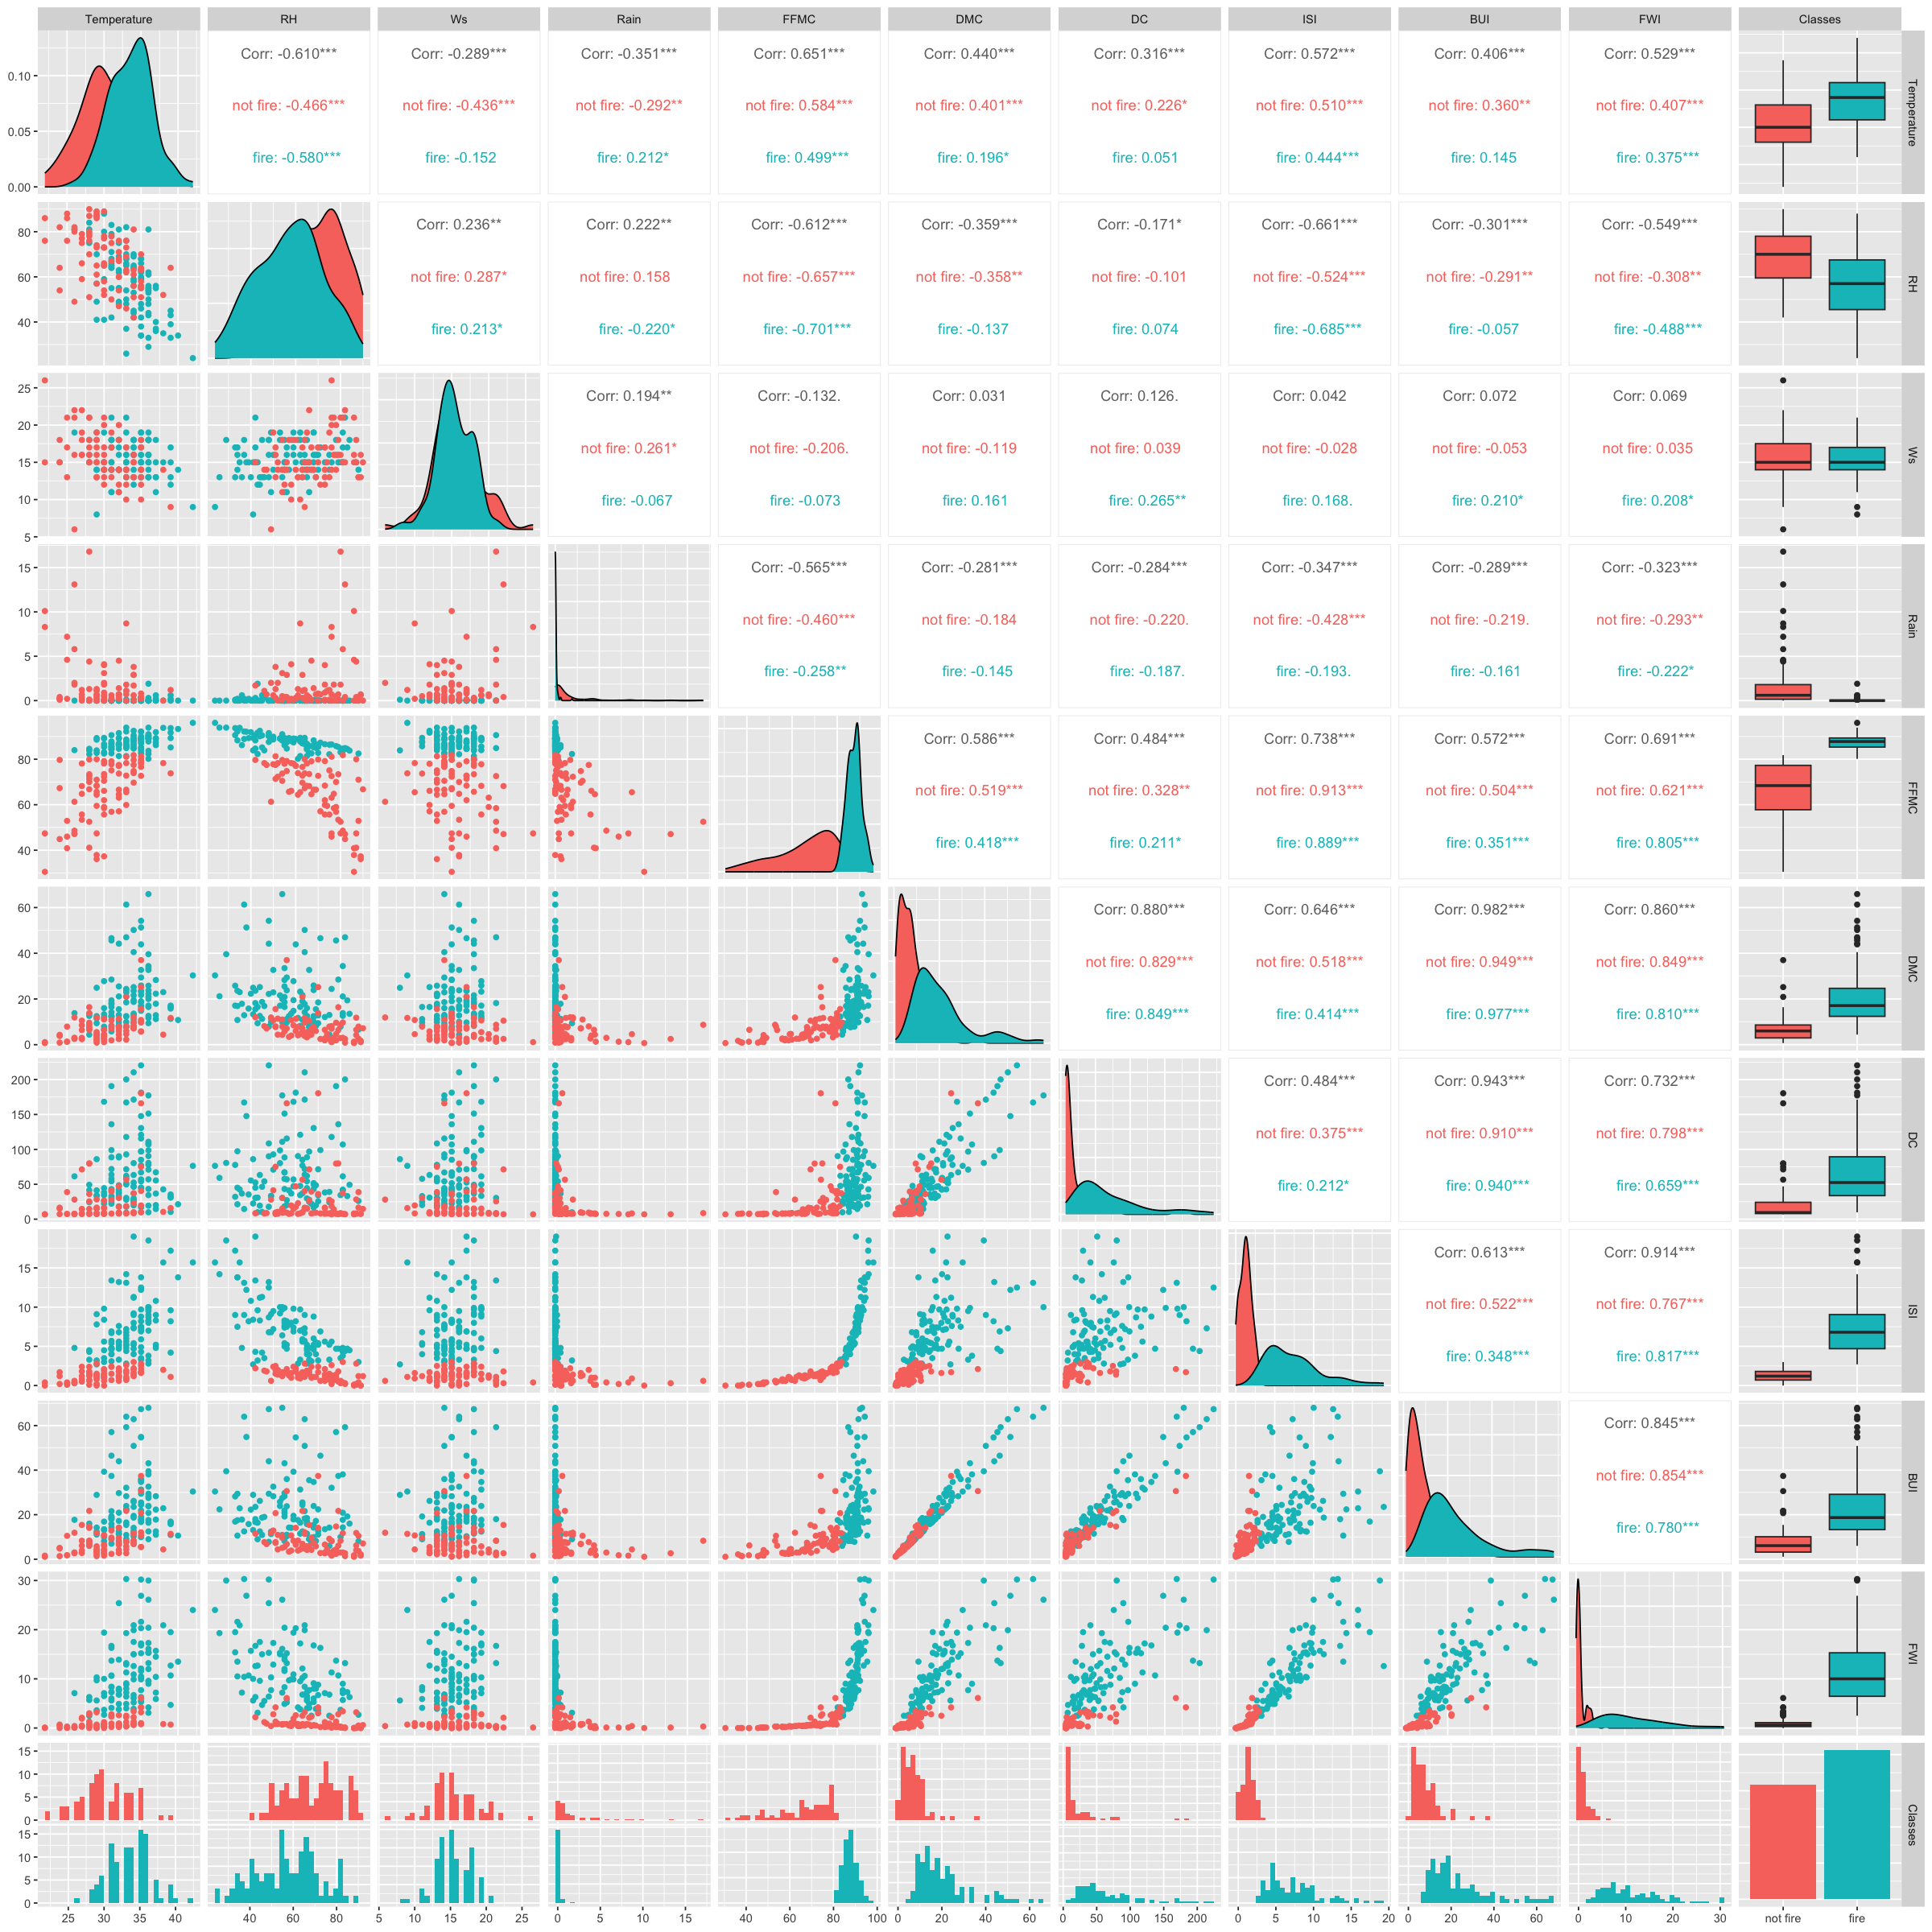

In [27]:
#resize so we can see the plots
options(repr.plot.width=20, repr.plot.height=20)
#ggpairs was used to do look at our preliminary data analysis, so we can see the general picture
fire_train %>% 
    ggpairs(aes(color = Classes))

Based on prior research on FWI indexes, we know that they're all calculated based on temperature, relative humidity, wind and rain. Additionally, `ISI` is calculated from Ws and FFMC, and `BUI` is calculated from DMC and DC. These 2 columns encompass information from other columns, so we use them to predict `Classes`. 

To confirm our choice, we make a plot with `ISI`, `BUI` and `Classes`.

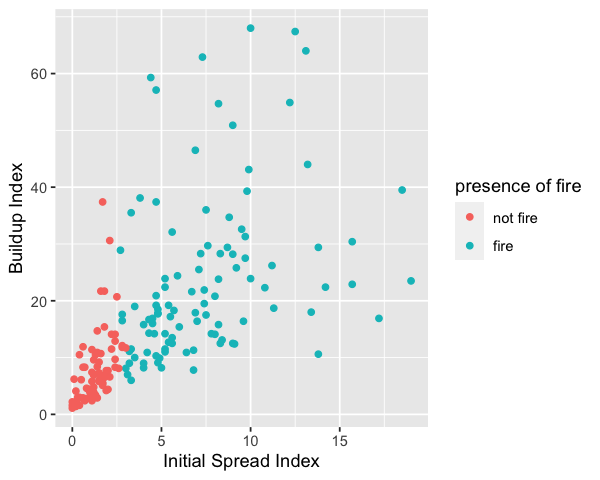

In [28]:
options(repr.plot.width=5, repr.plot.height=4)
ggplot(fire_train, aes(x = ISI, y = BUI, color = Classes)) +
    geom_point() +
    labs(x = "Initial Spread Index", y = "Buildup Index", color = "presence of fire")

There is a positive correlation between `ISI` and `BUI`, and there seems to be a distinction between the `Classes`! so `ISI` and `BUI` seems like a reasonable choice. 


We plan to visualise our model's results using a scatter plot that shows the `ISI` and `BUI` values on the axes, and color-coded based on the `Classes`.

**Expected outcomes and significance:**

 We hope that in the future, something like this can be used to predict real fires. Predicting fire will  be beneficial because it means we can mobilise firefighters faster, which helps stop the spread of fires. Hopefully, this can also lead to other questions, such as predicting the magnitude of a fire.


word count:498
<p style="font-size:10px">note : hyperlink urls and headers/title on markdown cells not included in the word count</p>


**References**

- Database URL: "https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv"

- Natural resources Canada: "https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi"

- Relevant papers: "Faroudja ABID et al. , â€œPredicting Forest Fire in Algeria using Data Mining Techniques: Case Study of the Decision Tree Algorithmâ€, International Conference on Advanced Intelligent Systems for Sustainable Development (AI2SD 2019) , 08 - 11 July , 2019, Marrakech, Morocco."

- Example project milestone 1: "https://github.com/UBC-DSCI/predict-airbnb-nightly-price/tree/v1.0.2"